# 2.1 Exploratory data analysis
Exploratory data analysis has been described in `data_analysis.ipnb`.

# 2.2 Data preprocessing

## 2.2.1 Loading images from the dataset
We use `image_dataset_from_directory` from tensorflow to load images in batches of size 64.

In [7]:
from tensorflow.keras.utils import image_dataset_from_directory

data_dir = "dataset/"

test_ds, train_ds, valid_ds = [
    image_dataset_from_directory(
        directory=f"{data_dir}{ds_name}",
        labels="inferred",
        label_mode="categorical", 
        image_size=(128, 128),
        batch_size=64,
    )
    for ds_name in [ "test", "train", "validation" ]
]


Found 359 files belonging to 36 classes.
Found 3115 files belonging to 36 classes.
Found 351 files belonging to 36 classes.


## 2.2.2 Data augmentation
We use various transformations, namely flipping and rotating the images to increase the variety. Very similar to data augumentation in our `pytorch` model.

In [2]:
from tensorflow import keras

data_augmentation = keras.Sequential([
    keras.layers.RandomFlip('horizontal_and_vertical'),
    keras.layers.RandomRotation(0.2),
])


## 2.2.3 Buffering and Prefetching
Using profiler we found out that IO operations take a large portion of computation time of our first model (`pytorch`). Tensorflow allows caching the datasets which speeds up the process of training a significantly.

In [3]:
from tensorflow import data

train_ds = train_ds.cache().prefetch(buffer_size=data.AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=data.AUTOTUNE)


## 2.3 Model choise

For our model we use pretrained `ResNet50` deep neural network. The main benefit of a deep network is that it can learn features at many different levels of abstraction, for example,  edges (at the lower layers) to very complex features (at the deeper layers) in the case of an image.


In [4]:
from tensorflow.keras.applications import ResNet50
from keras import Sequential, layers

res50 = ResNet50(include_top=False, weights = 'imagenet', input_shape=(128, 128, 3))
res50.trainable = False

model = Sequential()
model.add(res50)
model.add(layers.Flatten())
model.add(layers.Activation('relu'))
model.add(layers.Dense(36))
model.add(layers.Activation('softmax'))


model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 activation (Activation)     (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 36)                1179684   
                                                                 
 activation_1 (Activation)   (None, 36)                0         
                                                                 
Total params: 24,767,396
Trainable params: 1,179,684
Non-trainable params: 23,587,712
_________________________________________________________________


##  2.4 Model explanation

As we can see, the `ResNet50` model has 24,767,396 parameters, of which only `1,179,684` are trainable.

Since the model is of the same architecture as the model used in our `pytorch` model (ResNet18), more detailed information about the very internals of the model's design is described in `pytorch_model.ipynb` notebook.

# 2.5 Model training
## 2.5.1 Model compilation
Before training, we first need to compile the model.

As the parameters for compiling we choose `categorical_crossentropy` loss function, which is used in multi-class classification tasks, where an example can only belong to one out of many possible categories, and the model must decide which one.

Additionally, we chose `adam` to be our optimizer, which is a smart algorithm that takes care of updating the network weights. The alternative `sgd` optimizer had no visible effects on the training results.

In [5]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

## 2.5.2 Model fitting

To train the model, we use use 15 epochs. This number has proven to be efficient as the training usually stops between 9th and 12th epoch thanks to `EarlyStopping` callback.

Early stopping means stopping the training once monitored metric is no longer improving. In this case, the monitoring metric is 'loss'. The `patience` parameter manages the number of epochs with no improvement after which the training will be stopped. We found optimal results with setting this value to `3`.


In [8]:
from tensorflow.keras.callbacks import EarlyStopping

history = model.fit(
    train_ds,
    batch_size=64,
    epochs=15,
    validation_data=valid_ds,
    callbacks=[
        EarlyStopping(
            monitor='loss',
            patience=3
        )
    ]
)


Epoch 1/15


2022-05-11 17:44:04.032004: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-11 17:44:05.729758: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-05-11 17:44:07.111737: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 1/49 [..............................] - ETA: 4:37 - loss: 7.6665 - accuracy: 0.0000e+00

2022-05-11 17:44:09.339343: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 3/49 [>.............................] - ETA: 46s - loss: 15.7624 - accuracy: 0.0521  

2022-05-11 17:44:10.979664: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-05-11 17:44:10.981618: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 4/49 [=>............................] - ETA: 41s - loss: 16.0545 - accuracy: 0.0820

2022-05-11 17:44:11.819286: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 5/49 [==>...........................] - ETA: 40s - loss: 15.8467 - accuracy: 0.1063

2022-05-11 17:44:12.299089: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-05-11 17:44:12.912463: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-05-11 17:44:13.175952: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 7/49 [===>..........................] - ETA: 38s - loss: 15.2978 - accuracy: 0.1183

2022-05-11 17:44:14.280472: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-05-11 17:44:14.942944: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 8/49 [===>..........................] - ETA: 37s - loss: 14.7362 - accuracy: 0.1426

2022-05-11 17:44:15.166924: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-05-11 17:44:15.168168: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/49 [======>.......................] - ETA: 33s - loss: 13.5749 - accuracy: 0.1966

2022-05-11 17:44:18.660738: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


16/49 [========>.....................] - ETA: 29s - loss: 12.1355 - accuracy: 0.2646

2022-05-11 17:44:22.492888: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


18/49 [==========>...................] - ETA: 27s - loss: 11.5660 - accuracy: 0.2865

2022-05-11 17:44:24.205973: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


21/49 [===========>..................] - ETA: 25s - loss: 10.7674 - accuracy: 0.3162

2022-05-11 17:44:26.756036: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


25/49 [==============>...............] - ETA: 21s - loss: 10.0451 - accuracy: 0.3487

2022-05-11 17:44:30.452980: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


28/49 [================>.............] - ETA: 18s - loss: 9.6029 - accuracy: 0.3683

2022-05-11 17:44:33.323976: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


29/49 [================>.............] - ETA: 18s - loss: 9.4271 - accuracy: 0.3734

2022-05-11 17:44:34.456162: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


30/49 [=================>............] - ETA: 17s - loss: 9.3409 - accuracy: 0.3760

2022-05-11 17:44:34.903449: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


31/49 [=================>............] - ETA: 16s - loss: 9.1967 - accuracy: 0.3831

2022-05-11 17:44:36.262932: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


38/49 [======================>.......] - ETA: 9s - loss: 8.3715 - accuracy: 0.4157 

2022-05-11 17:44:42.555467: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


49/49 [==============================] - ETA: 0s - loss: 7.6447 - accuracy: 0.4514

2022-05-11 17:44:51.668273: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-05-11 17:44:52.885584: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


49/49 [==============================] - 55s 1s/step - loss: 7.6447 - accuracy: 0.4514 - val_loss: 0.9295 - val_accuracy: 0.9003
Epoch 2/15


2022-05-11 17:45:00.060032: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-05-11 17:45:01.570809: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 1/49 [..............................] - ETA: 4:00 - loss: 0.9975 - accuracy: 0.9062

2022-05-11 17:45:04.025005: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 3/49 [>.............................] - ETA: 54s - loss: 0.8921 - accuracy: 0.9062 

2022-05-11 17:45:05.999527: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-05-11 17:45:06.001906: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 4/49 [=>............................] - ETA: 48s - loss: 0.7522 - accuracy: 0.9180

2022-05-11 17:45:07.005804: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 5/49 [==>...........................] - ETA: 46s - loss: 0.8280 - accuracy: 0.9156

2022-05-11 17:45:07.534436: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-05-11 17:45:08.332872: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-05-11 17:45:08.604294: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 7/49 [===>..........................] - ETA: 44s - loss: 0.9005 - accuracy: 0.9018

2022-05-11 17:45:09.800100: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 8/49 [===>..........................] - ETA: 43s - loss: 1.0278 - accuracy: 0.8926

2022-05-11 17:45:10.614390: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-05-11 17:45:10.809368: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-05-11 17:45:10.820966: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/49 [======>.......................] - ETA: 38s - loss: 0.9743 - accuracy: 0.8893

2022-05-11 17:45:14.804829: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


16/49 [========>.....................] - ETA: 33s - loss: 1.0817 - accuracy: 0.8867

2022-05-11 17:45:19.051923: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


18/49 [==========>...................] - ETA: 31s - loss: 1.0120 - accuracy: 0.8906

2022-05-11 17:45:20.857166: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


21/49 [===========>..................] - ETA: 28s - loss: 1.0992 - accuracy: 0.8832

2022-05-11 17:45:23.674408: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


25/49 [==============>...............] - ETA: 24s - loss: 1.1448 - accuracy: 0.8769

2022-05-11 17:45:27.712101: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


28/49 [================>.............] - ETA: 21s - loss: 1.2069 - accuracy: 0.8717

2022-05-11 17:45:30.837067: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


29/49 [================>.............] - ETA: 20s - loss: 1.2039 - accuracy: 0.8707

2022-05-11 17:45:32.254247: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


30/49 [=================>............] - ETA: 19s - loss: 1.1909 - accuracy: 0.8708

2022-05-11 17:45:32.714899: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


31/49 [=================>............] - ETA: 18s - loss: 1.1877 - accuracy: 0.8705

2022-05-11 17:45:34.151846: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


38/49 [======================>.......] - ETA: 11s - loss: 1.1496 - accuracy: 0.8721

2022-05-11 17:45:41.482891: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


49/49 [==============================] - ETA: 0s - loss: 1.1288 - accuracy: 0.8742

2022-05-11 17:45:51.198113: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-05-11 17:45:52.512855: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


49/49 [==============================] - 60s 1s/step - loss: 1.1288 - accuracy: 0.8742 - val_loss: 0.7192 - val_accuracy: 0.9316
Epoch 3/15


2022-05-11 17:45:59.848463: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-05-11 17:46:01.418055: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 1/49 [..............................] - ETA: 4:13 - loss: 0.5717 - accuracy: 0.9531

2022-05-11 17:46:04.034348: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 3/49 [>.............................] - ETA: 56s - loss: 0.4747 - accuracy: 0.9635 

2022-05-11 17:46:06.078137: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-05-11 17:46:06.081189: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 4/49 [=>............................] - ETA: 51s - loss: 0.6782 - accuracy: 0.9531

2022-05-11 17:46:07.208081: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 5/49 [==>...........................] - ETA: 49s - loss: 0.6902 - accuracy: 0.9438

2022-05-11 17:46:07.733331: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-05-11 17:46:08.568193: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-05-11 17:46:08.868764: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 7/49 [===>..........................] - ETA: 47s - loss: 0.7669 - accuracy: 0.9375

2022-05-11 17:46:10.109325: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 8/49 [===>..........................] - ETA: 45s - loss: 0.9777 - accuracy: 0.9316

2022-05-11 17:46:11.033919: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-05-11 17:46:11.151429: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-05-11 17:46:11.265340: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/49 [======>.......................] - ETA: 40s - loss: 0.8581 - accuracy: 0.9297

2022-05-11 17:46:15.353922: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


16/49 [========>.....................] - ETA: 35s - loss: 0.7968 - accuracy: 0.9307

2022-05-11 17:46:19.933958: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


18/49 [==========>...................] - ETA: 33s - loss: 0.7491 - accuracy: 0.9366

2022-05-11 17:46:21.796203: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


21/49 [===========>..................] - ETA: 29s - loss: 0.6919 - accuracy: 0.9397

2022-05-11 17:46:24.839254: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


25/49 [==============>...............] - ETA: 25s - loss: 0.7294 - accuracy: 0.9381

2022-05-11 17:46:29.052755: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


28/49 [================>.............] - ETA: 22s - loss: 0.6892 - accuracy: 0.9408

2022-05-11 17:46:32.243125: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


29/49 [================>.............] - ETA: 21s - loss: 0.6673 - accuracy: 0.9423

2022-05-11 17:46:33.688249: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


30/49 [=================>............] - ETA: 20s - loss: 0.6523 - accuracy: 0.9432

2022-05-11 17:46:34.126004: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


31/49 [=================>............] - ETA: 19s - loss: 0.6679 - accuracy: 0.9420

2022-05-11 17:46:35.670549: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


38/49 [======================>.......] - ETA: 11s - loss: 0.6108 - accuracy: 0.9445

2022-05-11 17:46:42.726899: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


49/49 [==============================] - ETA: 0s - loss: 0.5968 - accuracy: 0.9445

2022-05-11 17:46:52.255038: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-05-11 17:46:53.586205: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


49/49 [==============================] - 61s 1s/step - loss: 0.5968 - accuracy: 0.9445 - val_loss: 0.7150 - val_accuracy: 0.9516
Epoch 4/15


2022-05-11 17:47:01.382084: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-05-11 17:47:02.976032: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 1/49 [..............................] - ETA: 4:16 - loss: 0.2537 - accuracy: 0.9688

2022-05-11 17:47:05.623443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 3/49 [>.............................] - ETA: 57s - loss: 0.4432 - accuracy: 0.9688 

2022-05-11 17:47:07.695960: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-05-11 17:47:07.700235: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 4/49 [=>............................] - ETA: 53s - loss: 0.3353 - accuracy: 0.9766

2022-05-11 17:47:08.855569: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 5/49 [==>...........................] - ETA: 51s - loss: 0.4118 - accuracy: 0.9719

2022-05-11 17:47:09.444091: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-05-11 17:47:10.302808: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-05-11 17:47:10.622101: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 7/49 [===>..........................] - ETA: 48s - loss: 0.3697 - accuracy: 0.9665

2022-05-11 17:47:11.894472: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 8/49 [===>..........................] - ETA: 47s - loss: 0.3316 - accuracy: 0.9688

2022-05-11 17:47:12.796354: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-05-11 17:47:12.964896: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-05-11 17:47:13.055339: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/49 [======>.......................] - ETA: 41s - loss: 0.3163 - accuracy: 0.9661

2022-05-11 17:47:17.234411: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


16/49 [========>.....................] - ETA: 35s - loss: 0.3189 - accuracy: 0.9648

2022-05-11 17:47:21.760683: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


18/49 [==========>...................] - ETA: 33s - loss: 0.3155 - accuracy: 0.9627

2022-05-11 17:47:23.640061: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


21/49 [===========>..................] - ETA: 29s - loss: 0.3477 - accuracy: 0.9621

2022-05-11 17:47:26.414306: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


25/49 [==============>...............] - ETA: 25s - loss: 0.3647 - accuracy: 0.9619

2022-05-11 17:47:30.492406: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


28/49 [================>.............] - ETA: 22s - loss: 0.3487 - accuracy: 0.9621

2022-05-11 17:47:33.645151: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


29/49 [================>.............] - ETA: 21s - loss: 0.3443 - accuracy: 0.9617

2022-05-11 17:47:35.039501: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


30/49 [=================>............] - ETA: 20s - loss: 0.3442 - accuracy: 0.9599

2022-05-11 17:47:35.465986: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


31/49 [=================>............] - ETA: 19s - loss: 0.3334 - accuracy: 0.9612

2022-05-11 17:47:37.013831: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


38/49 [======================>.......] - ETA: 11s - loss: 0.3832 - accuracy: 0.9597

2022-05-11 17:47:44.176962: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


49/49 [==============================] - ETA: 0s - loss: 0.4200 - accuracy: 0.9589

2022-05-11 17:47:53.785471: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-05-11 17:47:55.168701: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


49/49 [==============================] - 62s 1s/step - loss: 0.4200 - accuracy: 0.9589 - val_loss: 0.7893 - val_accuracy: 0.9601
Epoch 5/15


2022-05-11 17:48:03.780237: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-05-11 17:48:05.445292: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 1/49 [..............................] - ETA: 4:35 - loss: 0.5940 - accuracy: 0.9375

2022-05-11 17:48:08.379962: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 3/49 [>.............................] - ETA: 1:06 - loss: 0.3094 - accuracy: 0.9583

2022-05-11 17:48:10.791193: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-05-11 17:48:10.802594: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 4/49 [=>............................] - ETA: 1:00 - loss: 0.2730 - accuracy: 0.9609

2022-05-11 17:48:12.095731: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 5/49 [==>...........................] - ETA: 58s - loss: 0.2260 - accuracy: 0.9656 

2022-05-11 17:48:12.815996: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-05-11 17:48:13.825395: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 6/49 [==>...........................] - ETA: 58s - loss: 0.1921 - accuracy: 0.9688

2022-05-11 17:48:14.216242: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 7/49 [===>..........................] - ETA: 55s - loss: 0.2211 - accuracy: 0.9621

2022-05-11 17:48:15.436133: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-05-11 17:48:16.387018: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 8/49 [===>..........................] - ETA: 53s - loss: 0.2928 - accuracy: 0.9590

2022-05-11 17:48:16.615685: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-05-11 17:48:16.635045: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/49 [======>.......................] - ETA: 46s - loss: 0.2304 - accuracy: 0.9635

2022-05-11 17:48:21.350249: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


16/49 [========>.....................] - ETA: 39s - loss: 0.2503 - accuracy: 0.9580

2022-05-11 17:48:26.351685: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


18/49 [==========>...................] - ETA: 37s - loss: 0.2694 - accuracy: 0.9575

2022-05-11 17:48:28.247988: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


21/49 [===========>..................] - ETA: 32s - loss: 0.4041 - accuracy: 0.9531

2022-05-11 17:48:31.209529: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


25/49 [==============>...............] - ETA: 27s - loss: 0.3993 - accuracy: 0.9569

2022-05-11 17:48:35.478483: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


28/49 [================>.............] - ETA: 24s - loss: 0.4072 - accuracy: 0.9565

2022-05-11 17:48:38.782078: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


29/49 [================>.............] - ETA: 22s - loss: 0.3932 - accuracy: 0.9580

2022-05-11 17:48:40.291166: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


30/49 [=================>............] - ETA: 21s - loss: 0.3835 - accuracy: 0.9583

2022-05-11 17:48:40.737903: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


31/49 [=================>............] - ETA: 20s - loss: 0.3761 - accuracy: 0.9587

2022-05-11 17:48:42.463537: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


38/49 [======================>.......] - ETA: 12s - loss: 0.3477 - accuracy: 0.9601

2022-05-11 17:48:51.444141: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


49/49 [==============================] - ETA: 0s - loss: 0.3863 - accuracy: 0.9624

2022-05-11 17:49:03.031712: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-05-11 17:49:04.496224: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


49/49 [==============================] - 70s 1s/step - loss: 0.3863 - accuracy: 0.9624 - val_loss: 0.5580 - val_accuracy: 0.9658
Epoch 6/15


2022-05-11 17:49:13.604552: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-05-11 17:49:15.366554: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 2/49 [>.............................] - ETA: 1:17 - loss: 0.2023 - accuracy: 0.9609

2022-05-11 17:49:19.339734: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 3/49 [>.............................] - ETA: 1:17 - loss: 0.1382 - accuracy: 0.9740

2022-05-11 17:49:21.968160: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-05-11 17:49:21.974756: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 4/49 [=>............................] - ETA: 1:17 - loss: 0.1037 - accuracy: 0.9805

2022-05-11 17:49:23.470345: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 5/49 [==>...........................] - ETA: 1:11 - loss: 0.2797 - accuracy: 0.9750

2022-05-11 17:49:24.420685: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 6/49 [==>...........................] - ETA: 1:12 - loss: 0.2495 - accuracy: 0.9766

2022-05-11 17:49:25.834873: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-05-11 17:49:26.441619: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 7/49 [===>..........................] - ETA: 1:09 - loss: 0.4015 - accuracy: 0.9754

2022-05-11 17:49:28.159325: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 8/49 [===>..........................] - ETA: 1:06 - loss: 0.4080 - accuracy: 0.9746

2022-05-11 17:49:29.604439: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-05-11 17:49:29.620262: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-05-11 17:49:29.955472: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/49 [======>.......................] - ETA: 56s - loss: 0.3677 - accuracy: 0.9727

2022-05-11 17:49:35.718313: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


16/49 [========>.....................] - ETA: 49s - loss: 0.3173 - accuracy: 0.9727

2022-05-11 17:49:41.134569: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


18/49 [==========>...................] - ETA: 46s - loss: 0.3559 - accuracy: 0.9696

2022-05-11 17:49:43.860080: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


21/49 [===========>..................] - ETA: 41s - loss: 0.3338 - accuracy: 0.9710

2022-05-11 17:49:47.211475: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


25/49 [==============>...............] - ETA: 34s - loss: 0.3510 - accuracy: 0.9694

2022-05-11 17:49:52.648130: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


28/49 [================>.............] - ETA: 30s - loss: 0.3769 - accuracy: 0.9654

2022-05-11 17:49:56.914118: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


29/49 [================>.............] - ETA: 28s - loss: 0.3684 - accuracy: 0.9661

2022-05-11 17:49:58.927624: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


30/49 [=================>............] - ETA: 27s - loss: 0.3858 - accuracy: 0.9651

2022-05-11 17:49:59.513058: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


31/49 [=================>............] - ETA: 25s - loss: 0.3758 - accuracy: 0.9652

2022-05-11 17:50:01.663513: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


38/49 [======================>.......] - ETA: 15s - loss: 0.4154 - accuracy: 0.9626

2022-05-11 17:50:10.722497: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


49/49 [==============================] - ETA: 0s - loss: 0.4036 - accuracy: 0.9618

2022-05-11 17:50:23.038063: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-05-11 17:50:24.486549: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


49/49 [==============================] - 80s 2s/step - loss: 0.4036 - accuracy: 0.9618 - val_loss: 0.6800 - val_accuracy: 0.9544
Epoch 7/15


2022-05-11 17:50:33.458342: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-05-11 17:50:35.171920: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 1/49 [..............................] - ETA: 4:47 - loss: 3.6705e-04 - accuracy: 1.0000

2022-05-11 17:50:38.303363: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 3/49 [>.............................] - ETA: 1:13 - loss: 0.2906 - accuracy: 0.9896  

2022-05-11 17:50:41.056702: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-05-11 17:50:41.071037: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 4/49 [=>............................] - ETA: 1:06 - loss: 0.2764 - accuracy: 0.9805

2022-05-11 17:50:42.506694: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 5/49 [==>...........................] - ETA: 1:03 - loss: 0.3964 - accuracy: 0.9750

2022-05-11 17:50:43.313984: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-05-11 17:50:44.514131: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 6/49 [==>...........................] - ETA: 1:04 - loss: 0.3852 - accuracy: 0.9688

2022-05-11 17:50:45.039413: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 7/49 [===>..........................] - ETA: 1:02 - loss: 0.3439 - accuracy: 0.9710

2022-05-11 17:50:46.603455: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 8/49 [===>..........................] - ETA: 1:00 - loss: 0.3448 - accuracy: 0.9688

2022-05-11 17:50:47.937207: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-05-11 17:50:47.964458: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-05-11 17:50:48.340801: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/49 [======>.......................] - ETA: 52s - loss: 0.5111 - accuracy: 0.9635

2022-05-11 17:50:54.166879: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


16/49 [========>.....................] - ETA: 46s - loss: 0.5526 - accuracy: 0.9609

2022-05-11 17:50:59.449182: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


18/49 [==========>...................] - ETA: 43s - loss: 0.5327 - accuracy: 0.9635

2022-05-11 17:51:01.859952: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


21/49 [===========>..................] - ETA: 38s - loss: 0.4905 - accuracy: 0.9650

2022-05-11 17:51:05.351172: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


25/49 [==============>...............] - ETA: 32s - loss: 0.4586 - accuracy: 0.9669

2022-05-11 17:51:10.527081: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


28/49 [================>.............] - ETA: 28s - loss: 0.4322 - accuracy: 0.9660

2022-05-11 17:51:14.515753: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


29/49 [================>.............] - ETA: 27s - loss: 0.4644 - accuracy: 0.9655

2022-05-11 17:51:16.452813: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


30/49 [=================>............] - ETA: 25s - loss: 0.4490 - accuracy: 0.9667

2022-05-11 17:51:16.949920: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


31/49 [=================>............] - ETA: 24s - loss: 0.4356 - accuracy: 0.9672

2022-05-11 17:51:19.015151: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


38/49 [======================>.......] - ETA: 14s - loss: 0.3935 - accuracy: 0.9696

2022-05-11 17:51:27.867088: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


49/49 [==============================] - ETA: 0s - loss: 0.4515 - accuracy: 0.9679

2022-05-11 17:51:39.406996: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-05-11 17:51:40.937264: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


49/49 [==============================] - 77s 1s/step - loss: 0.4515 - accuracy: 0.9679 - val_loss: 0.4115 - val_accuracy: 0.9601
Epoch 8/15


2022-05-11 17:51:50.461182: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-05-11 17:51:52.191280: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 1/49 [..............................] - ETA: 4:51 - loss: 0.0653 - accuracy: 0.9844

2022-05-11 17:51:55.326757: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 3/49 [>.............................] - ETA: 1:14 - loss: 0.1378 - accuracy: 0.9792

2022-05-11 17:51:58.163207: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-05-11 17:51:58.165769: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 4/49 [=>............................] - ETA: 1:07 - loss: 0.1705 - accuracy: 0.9766

2022-05-11 17:51:59.567345: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 5/49 [==>...........................] - ETA: 1:04 - loss: 0.1756 - accuracy: 0.9750

2022-05-11 17:52:00.418937: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-05-11 17:52:01.661930: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 6/49 [==>...........................] - ETA: 1:05 - loss: 0.1659 - accuracy: 0.9740

2022-05-11 17:52:02.196150: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 7/49 [===>..........................] - ETA: 1:03 - loss: 0.1442 - accuracy: 0.9777

2022-05-11 17:52:03.720496: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 8/49 [===>..........................] - ETA: 1:01 - loss: 0.2256 - accuracy: 0.9746

2022-05-11 17:52:05.093229: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-05-11 17:52:05.110490: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-05-11 17:52:05.444005: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


12/49 [======>.......................] - ETA: 54s - loss: 0.2122 - accuracy: 0.9714

2022-05-11 17:52:11.844876: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


16/49 [========>.....................] - ETA: 48s - loss: 0.2909 - accuracy: 0.9707

2022-05-11 17:52:17.497518: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


18/49 [==========>...................] - ETA: 45s - loss: 0.3025 - accuracy: 0.9688

2022-05-11 17:52:19.913999: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


21/49 [===========>..................] - ETA: 40s - loss: 0.4035 - accuracy: 0.9695

2022-05-11 17:52:23.730298: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


25/49 [==============>...............] - ETA: 34s - loss: 0.4234 - accuracy: 0.9700

2022-05-11 17:52:29.361037: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


28/49 [================>.............] - ETA: 30s - loss: 0.3831 - accuracy: 0.9715

2022-05-11 17:52:33.730622: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


29/49 [================>.............] - ETA: 28s - loss: 0.3878 - accuracy: 0.9704

2022-05-11 17:52:35.884893: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


30/49 [=================>............] - ETA: 27s - loss: 0.3767 - accuracy: 0.9708

2022-05-11 17:52:36.528454: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


31/49 [=================>............] - ETA: 25s - loss: 0.3791 - accuracy: 0.9703

2022-05-11 17:52:38.790458: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


38/49 [======================>.......] - ETA: 15s - loss: 0.3642 - accuracy: 0.9729

2022-05-11 17:52:48.612826: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


49/49 [==============================] - ETA: 0s - loss: 0.3998 - accuracy: 0.9701

2022-05-11 17:53:00.481764: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-05-11 17:53:01.904690: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


49/49 [==============================] - 81s 2s/step - loss: 0.3998 - accuracy: 0.9701 - val_loss: 0.5674 - val_accuracy: 0.9573


## 2.5.3 Training accuracy over epochs
As we can see, the accuracy shoots up high in the very early epochs and only improves by little in the later epochs.

Without the mentioned `EarlyStopping` callback, we observed overtraining on data and decrease accuracy with later epochs.

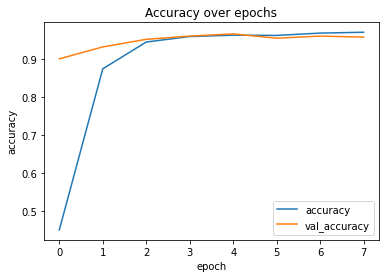

In [10]:
import pandas as pd
import matplotlib.pyplot as plt


pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy over epochs")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()

# 2.6 Model interpretation
The model has learned how to successfully recognize 36 classes of fruits and vegtables by adjusting it's trainable parameters.

Unfortunately, in case of neural networks, we cannot see very deep into the significance of individual image properties.

# 2.7 Model evaluation
## 2.7.1 Model accuracy
The observed accuracy on the test dataset seems to be always above the 94% threshold.

It is worth noting, that the testing dataset consists of only 10 images per class, 360 images in total, so the sample may be too small to come to a definitive conlusion.

In [11]:
model.evaluate(test_ds, verbose=1)

2022-05-11 17:53:33.511052: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-05-11 17:53:35.277027: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


6/6 [==============================] - 7s 659ms/step - loss: 0.5548 - accuracy: 0.9582


[0.5547966361045837, 0.9582172632217407]

We can visualize some of the original and predicted labels for images in the test dataset.

2022-05-11 17:53:42.155771: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-05-11 17:53:44.027436: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


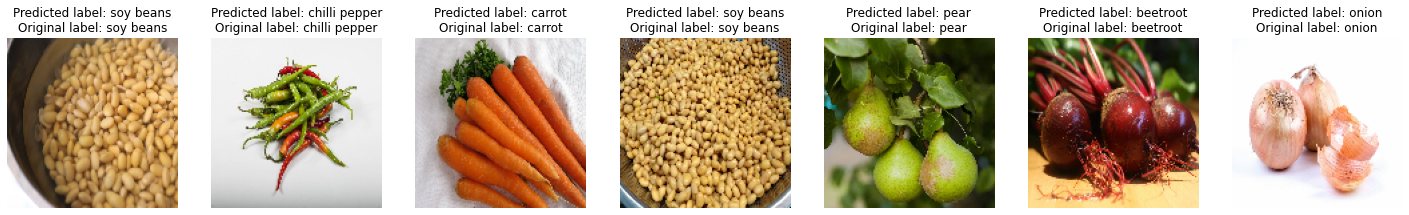

In [12]:
label_names = test_ds.class_names

plt.figure(figsize=(25,30))

sample_size = 7

for images, labels in test_ds.take(1):
    prediction = model.predict(images)

    for i in range(sample_size):
        plt.subplot(1, sample_size, i + 1)
        plt.imshow(images[i].numpy().astype('int'))
        
        pred_label = tf.argmax(tf.round(prediction[i]))
        orig_label = tf.argmax(labels[i])
        
        plt.title(f"Predicted label: {label_names[pred_label]}\n"
                  f"Original label: {label_names[orig_label]}")

        plt.grid(True)
        plt.axis('off')
        
    plt.show()



## 2.7.2 Confusion matrix

Plotting the confusion matrix of the test dataset can tell us more about results of the model, especially about which classes are the most likely to be misclassified.

2022-05-11 17:54:05.420919: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-05-11 17:54:07.398240: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


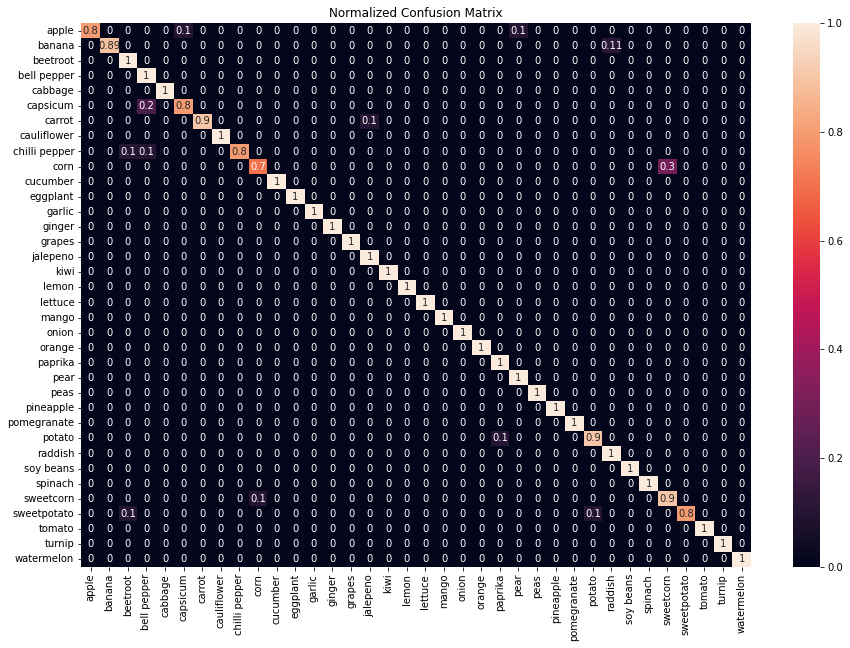

In [13]:
import numpy as np


def get_label_names(labels):
    label_names = test_ds.class_names
    label_indices = [tf.argmax(label) for label in labels]
    return [label_names[i] for i in label_indices]

images, labels = tuple(zip(*test_ds))

# "De-batch" images and labels from batches of 64
images = np.concatenate(images)
labels = np.concatenate(labels)

pred = tf.round(model.predict(images))

y_pred = get_label_names(pred)
y_test = get_label_names(labels)


from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(y_test)), 
            yticklabels = sorted(set(y_test)),
            )

plt.title('Normalized Confusion Matrix')
plt.show()
